In [1]:
# Dependencies:
# pip: scikit-learn, anndata, scanpy
#
# Modified from the Python starter kit for the NeurIPS 2021 Single-Cell Competition.
# Parts with `TODO` are supposed to be changed by you.
#
# More documentation:
#
# https://viash.io/docs/creating_components/python/

In [2]:
import logging
import anndata as ad
import sys

from scipy.sparse import csc_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import numpy as np

logging.basicConfig(level=logging.INFO)

In [3]:
## VIASH START
# Anything within this block will be removed by `viash` and will be
# replaced with the parameters as specified in your config.vsh.yaml.
meta = { 'resources_dir': '.' }

par = { 
    'input_train_mod1': 'sample_data/openproblems_bmmc_cite_starter/openproblems_bmmc_cite_starter.train_mod1.h5ad',
    'input_train_mod2': 'sample_data/openproblems_bmmc_cite_starter/openproblems_bmmc_cite_starter.train_mod2.h5ad',
    'input_test_mod1': 'sample_data/openproblems_bmmc_cite_starter/openproblems_bmmc_cite_starter.test_mod1.h5ad',
    'distance_method': 'minkowski',
    'output': 'output.h5ad',
    'n_pcs': 50,
}
## VIASH END
test_mod2_file = 'sample_data/openproblems_bmmc_cite_starter/openproblems_bmmc_cite_starter.test_mod2.h5ad '


In [4]:
## VIASH START
# Anything within this block will be removed by `viash` and will be
# replaced with the parameters as specified in your config.vsh.yaml.
meta = { 'resources_dir': '.' }

par = {
    'input_train_mod1': 'sample_data/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.train_mod1.h5ad',
    'input_train_mod2': 'sample_data/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.train_mod2.h5ad',
    'input_test_mod1': 'sample_data/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.test_mod1.h5ad',
    'distance_method': 'minkowski',
    'output': 'output.h5ad',
    'n_pcs': 50,
}
## VIASH END
test_mod2_file = 'sample_data/openproblems_bmmc_multiome_starter/openproblems_bmmc_multiome_starter.test_mod2.h5ad'


In [5]:
method_id = 'basic_beans'
sys.path.append(meta['resources_dir'])

In [6]:
logging.info('Reading `h5ad` files...')
input_train_mod1 = ad.read_h5ad(par['input_train_mod1'])
input_train_mod2 = ad.read_h5ad(par['input_train_mod2'])
input_test_mod1 = ad.read_h5ad(par['input_test_mod1'])



INFO:root:Reading `h5ad` files...


In [7]:

# TODO: implement own method
from beans import method
adata = method(input_train_mod1, input_train_mod2, input_test_mod1)

adata.uns["method_id"] = method_id



INFO:root:Performing dimensionality reduction on modality 1 values...
INFO:root:Performing dimensionality reduction on modality 2 values...
INFO:root:Running K nearest neigbors...


In [8]:

from scipy.sparse import issparse
issparse(adata.X)

True

In [9]:

logging.info('Storing annotated data...')
adata.write_h5ad(par['output'], compression = "gzip")


INFO:root:Storing annotated data...


In [10]:
from pygam import LinearGAM

In [11]:
from sklearn.decomposition import TruncatedSVD
logging.info('Performing dimensionality reduction on modality 1 values...')    
input_mod1 = ad.concat(
    {"train": input_train_mod1, "test": input_test_mod1},
    axis=0,
    join="outer",
    label="group",
    fill_value=0,
    index_unique="-"
)
    
embedder_mod1 = TruncatedSVD(n_components=50)
mod1_pca = embedder_mod1.fit_transform(input_mod1.X)

logging.info('Performing dimensionality reduction on modality 2 values...')
embedder_mod2 = TruncatedSVD(n_components=50)
mod2_pca = embedder_mod2.fit_transform(input_train_mod2.X)

# split dimred back up
X_train = mod1_pca[input_mod1.obs['group'] == 'train']
X_test = mod1_pca[input_mod1.obs['group'] == 'test']
y_train = mod2_pca
    
logging.info('Running Linear regression...')


INFO:root:Performing dimensionality reduction on modality 1 values...
INFO:root:Performing dimensionality reduction on modality 2 values...
INFO:root:Running Linear regression...


In [12]:
from matplotlib import pyplot as plt
import pandas as pd

In [13]:
print(input_train_mod1.uns['dataset_id'])
print(input_train_mod2.uns['dataset_id'])
print(input_test_mod1.uns['dataset_id'])

openproblems_bmmc_multiome_starter_PM_gex2atac
openproblems_bmmc_multiome_starter_PM_gex2atac
openproblems_bmmc_multiome_starter_PM_gex2atac


In [14]:
m1_tr = pd.DataFrame(X_train)
m1_te = pd.DataFrame(X_test)
m2_tr = pd.DataFrame(X_train)

In [15]:
input_train_mod2.shape

(221, 600)

In [16]:
import colorsys

import numpy as np

N = m1_tr.shape[0]
HSV = [(float(x)/N, 1, 1) for x in range(1,N+1)]
RGB = map(lambda x: colorsys.hsv_to_rgb(*x), HSV)


In [17]:
RGB

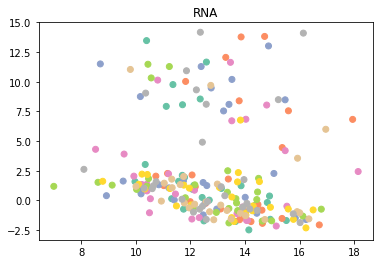

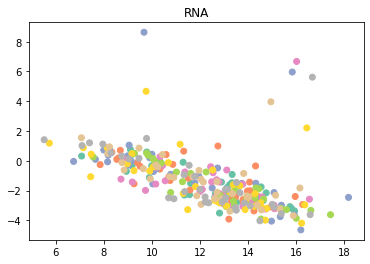

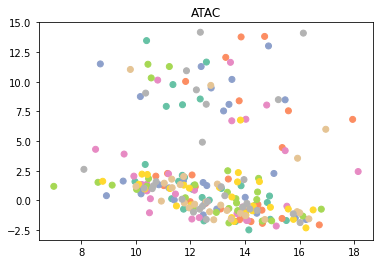

In [18]:
plt.scatter(m1_tr[0], m1_tr[1], c=m1_tr.index, cmap='Set2')
plt.title("RNA")
plt.show()

plt.scatter(m1_te[0], m1_te[1], c=m1_te.index, cmap='Set2')
plt.title("RNA")
plt.show()

plt.scatter(m2_tr[0], m2_tr[1], c=m2_tr.index, cmap='Set2')
plt.title("ATAC")
plt.show()


In [19]:
m1_tr.iloc[[0]]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,14.378852,-0.390654,1.40366,-0.896812,2.606131,-2.100747,0.466593,0.909991,-0.352511,0.21936,...,-0.829463,-0.966436,0.132311,0.378115,-0.223237,0.472652,0.486238,-0.707674,-1.119596,-0.853451


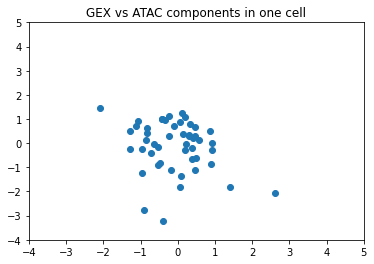

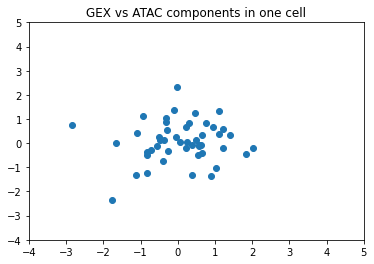

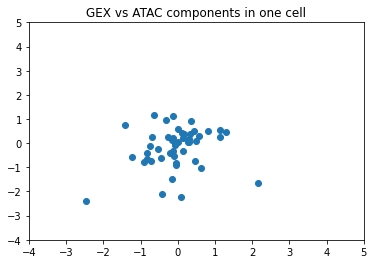

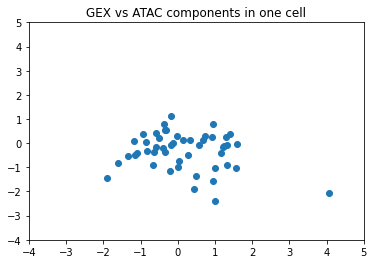

In [20]:
for i in [0,5,10,150]:
    plt.scatter(m1_tr.iloc[[i]], m1_te.iloc[[i]])
    plt.title("GEX vs ATAC components in one cell")

    axes = plt.gca()
    axes.set_xlim([-4,5])
    axes.set_ylim([-4,5])

    plt.show()


In [21]:
input_train_mod2.X.A

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

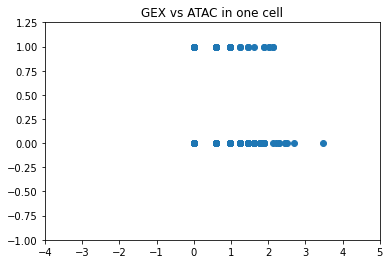

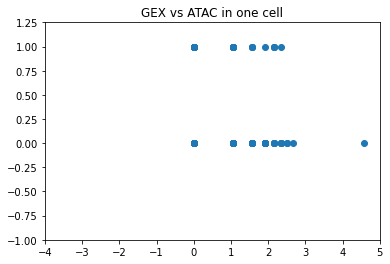

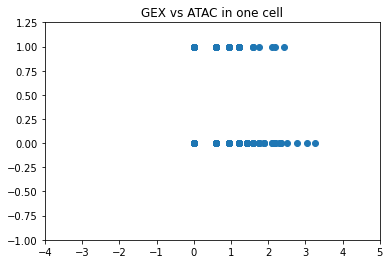

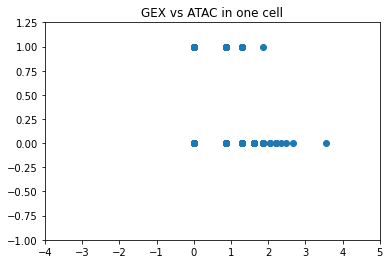

In [22]:
for i in [0,5,10,150]:
    plt.scatter(input_train_mod1.X[[i]].A, input_train_mod2.X[[i]].A)
    plt.title("GEX vs ATAC in one cell")

    axes = plt.gca()
    axes.set_xlim([-4,5])
    axes.set_ylim([-1,1.25])

    plt.show()


In [23]:
y_train.shape

(221, 50)

In [24]:
input_train_mod2.X.shape

(221, 600)

In [25]:
input_train_mod2

AnnData object with n_obs × n_vars = 221 × 600
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id'
    layers: 'counts'

In [26]:
from statistics import sqrt
from math import ceil, floor
N = X_train.shape[0]
k = ceil(sqrt(N))
kf = floor(sqrt(N))
kr = round(sqrt(N))

In [27]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [28]:
y_pred = neigh.predict(X_test)

In [29]:

# Project the predictions back to the modality 2 feature space
y_pred = y_pred @ embedder_mod2.components_

# Store as sparse matrix to be efficient. Note that this might require
# different classifiers/embedders before-hand. Not every class is able
# to support such data structures.
y_pred = csc_matrix(y_pred)

adata2 = ad.AnnData(
    X=y_pred,
    obs=input_test_mod1.obs,
    var=input_train_mod2.var,
    uns={
        'dataset_id': input_train_mod1.uns['dataset_id'],
        'method_id': 'starter_kit'
    },
)


In [30]:
true_test_mod2 = ad.read_h5ad(test_mod2_file)

In [31]:

from sklearn.metrics import mean_squared_error
def calculate_rmse(true_test_mod2, pred_test_mod2):
    return  mean_squared_error(true_test_mod2.X.toarray(), pred_test_mod2.X.toarray(), squared=False)

In [32]:
calculate_rmse(true_test_mod2, adata)

0.29968134

In [33]:
calculate_rmse(true_test_mod2, adata2)

0.29972288

In [34]:
#forward
tests_f={}
for i in range (1, 200,10):
    pred_data = method(input_train_mod1, input_train_mod2, input_test_mod1, k=i, d=50)
    tests_f[i]=calculate_rmse(true_test_mod2, pred_data)
tests_f

INFO:root:Performing dimensionality reduction on modality 1 values...
INFO:root:Performing dimensionality reduction on modality 2 values...
INFO:root:Running K nearest neigbors...
INFO:root:Performing dimensionality reduction on modality 1 values...
INFO:root:Performing dimensionality reduction on modality 2 values...
INFO:root:Running K nearest neigbors...
INFO:root:Performing dimensionality reduction on modality 1 values...
INFO:root:Performing dimensionality reduction on modality 2 values...
INFO:root:Running K nearest neigbors...
INFO:root:Performing dimensionality reduction on modality 1 values...
INFO:root:Performing dimensionality reduction on modality 2 values...
INFO:root:Running K nearest neigbors...
INFO:root:Performing dimensionality reduction on modality 1 values...
INFO:root:Performing dimensionality reduction on modality 2 values...
INFO:root:Running K nearest neigbors...
INFO:root:Performing dimensionality reduction on modality 1 values...
INFO:root:Performing dimension

{1: 0.37809813,
 11: 0.30257353,
 21: 0.29727805,
 31: 0.295071,
 41: 0.29401088,
 51: 0.29332057,
 61: 0.2926963,
 71: 0.29228976,
 81: 0.29205868,
 91: 0.2918943,
 101: 0.29175115,
 111: 0.29157683,
 121: 0.2914748,
 131: 0.291431,
 141: 0.29134932,
 151: 0.29129314,
 161: 0.29126135,
 171: 0.2912848,
 181: 0.29132807,
 191: 0.29134592}

#go backwards
tests={}
for i in range (2, 200, 10):
    pred_data = method(input_train_mod2, input_train_mod1, true_test_mod2, k=i)
    tests[i]=calculate_rmse(input_test_mod1, pred_data)
tests

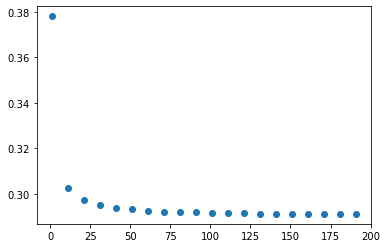

In [35]:
plt.scatter(tests_f.keys(), tests_f.values())

In [36]:
tests_f.keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191])